# Collect Commits Logs

In [111]:
import json
from tqdm import tqdm
from requests import get
from requests.auth import HTTPBasicAuth as Auth

def http_get(url, user, token):
  """
    This function runs one github api get request and decode the replied object as json
    Args:
      url:        the github api url
      user:        str, github username used for authorization
      token:       str, github personal access token, applied from here: https://github.com/settings/tokens
    
    Returns:
      json_reply:    list of dict, they are replied json object from the github api
  """
  result = get(url.format(page_num), auth=Auth(user, token))
  result_body = json.loads(result.text)
  return result_body
  

def get_all_commits(owner, repo, since, path, user, token):
  """
    This function tries to get all infos from a github api
    Args:
      owner:       str, owner of the repository
      repo:       str, name of the repository
      since:       str, start time of returned commits
      path:       str, only commits under this path would be returned
      user:        str, github username used for authorization
      token:       str, github personal access token, applied from here: https://github.com/settings/tokens
    
    Returns:
      commits_details:     list of dict, each of them is a commit logs
  """
  commits_sha = list()
  commits_details = list()
  
  # get the fisrt page github api reply to init a (pseudo) do-while loop
  page_num = 1
  url = "https://api.github.com/repos/{owner}/{repo}/commits?since={since}&per_page=100&path={path}".format(owner=owner, repo=repo, since=since, path=path)
  url += "&page={}"
  result_body = http_get(url.format(page_num), user, token)

  # if the replied result contains a non-empty json object
  # append them to commits and try to get the next page 
  while result_body:
    commits_sha += [x["sha"] for x in result_body]
    page_num += 1
    result_body = http_get(url.format(page_num), user, token)
  
  # get detailed commits
  url = "https://api.github.com/repos/{owner}/{repo}/commits/".format(owner=owner, repo=repo)
  url += "{}"
  commits_details = list()
  for sha in tqdm(commits_sha):
    reply_body = http_get(url.format(sha), user, token)
    commits_details.append(reply_body)

  return commits_details

In [112]:
# Constants
USER = ""                     # github username, used for authorization
TOKEN = ""    # github personal access tokens: access from https://github.com/settings/tokens
OWNER = "openstack"                   # the owner of the project to investigate
REPO = "neutron"                    # the project to investigate
SINCE = "2021-06-01T00:00:00Z"              # any commits after this time will be considered
PER_PAGE = "100"                    # maximun commits logs per request
PATH = "neutron"                    # any commits happend within this subpath will be returned

commits = get_all_commits(OWNER, REPO, SINCE, PATH, USER, TOKEN)

print("Commits Saved")
print("Total number of commits: {}".format(len(commits)))

100%|██████████| 490/490 [01:24<00:00,  5.81it/s]

Commits Saved
Total number of commits: 490


In [113]:
# save the logs
with open("{}_{}_commits_{}.json".format(OWNER, REPO, SINCE), "w") as f:
  json.dump(commits, f, indent=4)

# Count Module Edit Frequency

In [114]:
def count_module_edit_frequency(commits, path):

  """
    Count the add/delete frequency of directories under a given path 
    and sort the result based on 1) commits and 2) edit frequencies

    Args:
      commits:  list of dict, commit logs get from get_all_commits()
      path:    str, sub path
    Returns:
      edit_sorted_key:      list, list of keys, sorted descendingly based on modify_count
      commit_sorted_key:     list, list of keys, sorted descendingly based on commit_count
      add_count:        dict, addition count for each module
      delelte_count:      dict, delete count for each module
      modify_count:       dict, modification count for each module
      commit_count:       dict, commit count for each module
  """

  add_count = dict()
  delete_count = dict()
  modify_count = dict()
  commit_count = dict()

  # iterate on each commit record
  for record in tqdm(commits):
    # iterate on changed file lists
    for file in record["files"]:
      file_name = file["filename"] # edited file name
      if file_name.startswith(path):
        # get module
        module = file_name.split("/")[1]

        if module.endswith(".py"):
          # only a directory would be consider
          continue

        # count commit
        if module in commit_count:
          commit_count[module] += 1
        else:
          commit_count[module] = 1

        # count addition
        if module in add_count:
          add_count[module] += file["additions"]
        else:
          add_count[module] = file["additions"]

        # count deletion
        if module in delete_count:
          delete_count[module] += file["deletions"]
        else:
          delete_count[module] = file["deletions"]

        # count modification
        if module in modify_count:
          modify_count[module] += file["changes"]
        else:
          modify_count[module] = file["changes"]
  
  # sorts the frequency in decending order of modify_count
  edit_sorted_keys = sorted(modify_count.items(), key=lambda x:x[1], reverse=True)
  edit_sorted_keys = [k for k, v in edit_sorted_keys]

  # sorts the frequency in decending order of commit_count
  commit_sorted_keys = sorted(commit_count.items(), key=lambda x:x[1], reverse=True)
  commit_sorted_keys = [k for k, v in commit_sorted_keys]

  return edit_sorted_keys, commit_sorted_keys, add_count, delete_count, modify_count, commit_count

In [115]:
# count module edit frequency
edit_sorted_keys, commit_sorted_keys, add_count, delete_count, modify_count, commit_count = count_module_edit_frequency(commits, "neutron/")

100%|██████████| 490/490 [00:00<00:00, 61855.44it/s]


# Visualize: Top 12 Active Module by Edition

In [129]:
def display_sorted_result(key, add_count, delete_count, modify_count, commit_count):
  """
    Print out module infos based on sorted key
  """
  total_add = 0
  total_del = 0
  total_mod = 0
  for i, k in enumerate(key[:12]):
    # count total add
    add = add_count[k]
    total_add += add

    # count total del
    delete = delete_count[k]
    total_del += delete

    # count total mod
    mod = modify_count[k]
    total_mod += mod

    # count total commit
    cmt = commit_count[k]

    print("#{} [{}] Add:{} + Delete:{} = Modified:{}".format(i+1,k,add,delete,mod))
    print("   [{}] Commits:{}".format(k, cmt))

  return total_add, total_del, total_mod

In [130]:
# print edit frequency
print("Sorted based on Edition")
total_add, total_del, total_mod = display_sorted_result(edit_sorted_keys[:12], add_count, delete_count, modify_count, commit_count)
print("Total: [add] {} + [delete] {} = [modify] {}".format(total_add, total_del, total_mod))

Sorted based on Edition
#1 [tests] Add:19238 + Delete:7318 = Modified:26556
   [tests] Commits:773
#2 [plugins] Add:4275 + Delete:2284 = Modified:6559
   [plugins] Commits:267
#3 [db] Add:4556 + Delete:1747 = Modified:6303
   [db] Commits:282
#4 [agent] Add:2944 + Delete:883 = Modified:3827
   [agent] Commits:150
#5 [services] Add:1808 + Delete:978 = Modified:2786
   [services] Commits:154
#6 [objects] Add:838 + Delete:293 = Modified:1131
   [objects] Commits:92
#7 [extensions] Add:937 + Delete:52 = Modified:989
   [extensions] Commits:39
#8 [cmd] Add:929 + Delete:4 = Modified:933
   [cmd] Commits:19
#9 [quota] Add:178 + Delete:382 = Modified:560
   [quota] Commits:11
#10 [api] Add:314 + Delete:209 = Modified:523
   [api] Commits:33
#11 [conf] Add:414 + Delete:87 = Modified:501
   [conf] Commits:40
#12 [common] Add:338 + Delete:148 = Modified:486
   [common] Commits:54
Total: [add] 36769 + [delete] 14385 = [modify] 51154


In [131]:
import numpy as np
import matplotlib.pyplot as plt
def generate_bar_chart(keys, add_val, del_val, title):
  """
    Generate a bar chart
    Args:
      keys:     list, sorted keys
      add_val,    list, addition count
      del_val,    list, deletion count
      title:     str, title of the graph
  """

  plt.clf()

  # setup axis
  plt.xticks(np.arange(len(keys)),keys,rotation=270,fontsize=10)
  plt.title(title)

  # add bars
  plt.bar(keys, add_val, color="green", label="Additions")
  plt.bar(keys, [-x for x in del_val], color="red", label="Deletions")

  # add label
  plt.legend()

  # save fig
  plt.savefig("{}_bar.png".format("_".join(title.split(" "))), bbox_inches='tight')

In [132]:
def generate_pie_chart(key, val, title):
  # calculate percentage
  s = sum(val)
  val = [x/s for x in val]

  add_key = [x+" - {:.2f}%".format(y*100) for x, y in zip(key, val)]
  
  plt.clf()
  
  # draw a pie
  patches, texts = plt.pie(val)
  #patches, add_key, _ =  zip(*sorted(zip(patches, add_key, val),key=lambda x: x[2], reverse=True))
  
  # set label
  plt.legend(patches, add_key, bbox_to_anchor=(-0.1, 1.))

  # set title
  plt.title(title)

  plt.savefig("{}_pie.png".format("_".join(title.split(" "))), bbox_inches='tight')

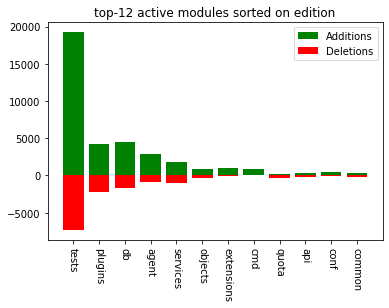

In [133]:
# generate bar chart of add/delete based on edition
keys = edit_sorted_keys[:12]
add_val = [add_count[k] for k in keys]
del_val = [delete_count[k] for k in keys]
cmt_val = [commit_count[k] for k in keys]

generate_bar_chart(keys, add_val, del_val, "top-12 active modules sorted on edition")

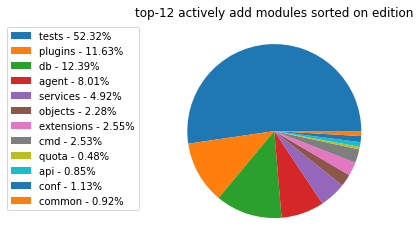

In [135]:
# generate pie chart of add based on edition
generate_pie_chart(keys, add_val, "top-12 actively add modules sorted on edition")

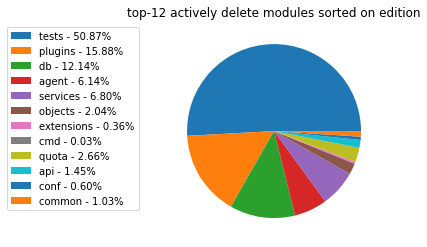

In [136]:
# generate pie chart of delete based on edition
generate_pie_chart(keys, del_val, "top-12 actively delete modules sorted on edition")

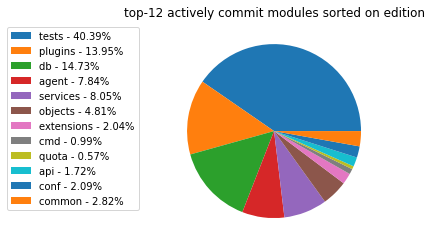

In [137]:
# generate pie chart of commit based on edition
generate_pie_chart(keys, cmt_val, "top-12 actively commit modules sorted on edition")

# Visualize: Top 12 Active Module by Commit

In [138]:
# print edit frequency
print("Sorted based on commit")
total_add, total_del, total_mod = display_sorted_result(commit_sorted_keys[:12], add_count, delete_count, modify_count, commit_count)
print("Total: [add] {} + [delete] {} = [modify] {}".format(total_add, total_del, total_mod))

Sorted based on commit
#1 [tests] Add:19238 + Delete:7318 = Modified:26556
   [tests] Commits:773
#2 [db] Add:4556 + Delete:1747 = Modified:6303
   [db] Commits:282
#3 [plugins] Add:4275 + Delete:2284 = Modified:6559
   [plugins] Commits:267
#4 [services] Add:1808 + Delete:978 = Modified:2786
   [services] Commits:154
#5 [agent] Add:2944 + Delete:883 = Modified:3827
   [agent] Commits:150
#6 [objects] Add:838 + Delete:293 = Modified:1131
   [objects] Commits:92
#7 [common] Add:338 + Delete:148 = Modified:486
   [common] Commits:54
#8 [conf] Add:414 + Delete:87 = Modified:501
   [conf] Commits:40
#9 [extensions] Add:937 + Delete:52 = Modified:989
   [extensions] Commits:39
#10 [api] Add:314 + Delete:209 = Modified:523
   [api] Commits:33
#11 [cmd] Add:929 + Delete:4 = Modified:933
   [cmd] Commits:19
#12 [quota] Add:178 + Delete:382 = Modified:560
   [quota] Commits:11
Total: [add] 36769 + [delete] 14385 = [modify] 51154


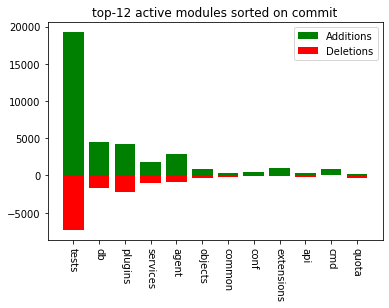

In [139]:
# generate bar chart of add/delete based on commit
keys = commit_sorted_keys[:12]
add_val = [add_count[k] for k in keys]
del_val = [delete_count[k] for k in keys]
cmt_val = [commit_count[k] for k in keys]

generate_bar_chart(keys, add_val, del_val, "top-12 active modules sorted on commit")

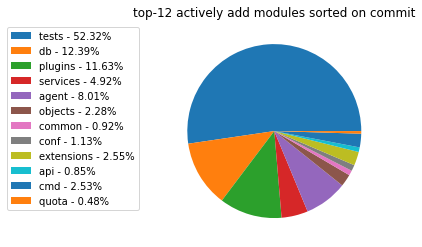

In [140]:
# generate pie chart of add based on commit
generate_pie_chart(keys, add_val, "top-12 actively add modules sorted on commit")

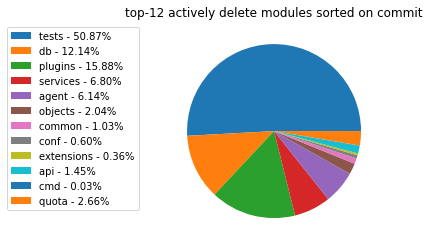

In [141]:
# generate pie chart of delete based on commit
generate_pie_chart(keys, del_val, "top-12 actively delete modules sorted on commit")

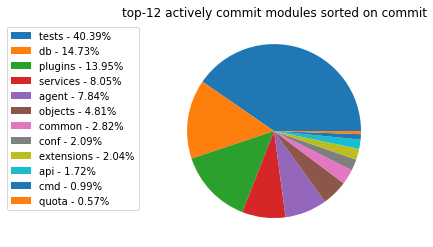

In [142]:
# generate pie chart of commits based on commit
generate_pie_chart(keys, cmt_val, "top-12 actively commit modules sorted on commit")